## Importando as bibliotecas:

In [8]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import random
from scipy.stats import norm

## Carregando o dataset e fazendo as configuracoes iniciais:

A funcao trasnforms.Compose([]) eh responsavel por aplicar uma serie de transformacoes e conversoes
nas imagens antes de passar para a rede neural, no caso, estamos aplicando somente a conversao para tensor.

Estamos usando o dataset MNIST, que possui dimensoes de exatamente 28x28. Estamos tambem fazendo uma divisao de 80%
do dataset para treino e 20% para teste do modelo alem de um random_split no proprio dataset, o que nao eh necessariamente otimo
pois existe uma chance de enviesar o modelo desbalanceando a distribuicao de numeros entre as secoes de teste e treino.

O batch size foi definido como 128, o que significa que o modelo somente ajustara os pesos apos 128 imagens vistas.

In [9]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transform,download = True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=100, shuffle=False)

image_dims_color = 784

## Declarando a classe do VAE:

No construtor da classe estamos criando as camadas do VAE, note que ate as camadas fc2_mu e fc2_sig estamos reduzindo o numero de neuronios e por consequencia
reduzindo o espaco latente, buscando resumir os dados a suas distribuicoes. Ja nas camadas posteriores as citadas anteriormente estamos aumentando novamente
o numero de neuronios, aumentando o espaco latente. Estamos usando a ReLU como funcao de ativacao para todas as camadas (com excecao da camada de saida onde estamos usando a funcao sigmoid).

Outro fator importante de se notar eh que as camadas fc2_mu e fc2_sig estao sendo usadas como media e variancia da distribuicao gaussiana construida apartir dos dados de entrada, no caso as imagens do dataset MNIST.

O metodo forward eh simplesmente onde ocorre a planificacao do espaco multidimensional, a reducao do espaco latente para criar a distribuicao gaussiana dos dados de entrada por parte do encoder e a reconstrucao dos dados de entrada por parte do decoder, ou seja, ele planifica os dados e passa por todas as camadas da rede neural (encoder e decoder).

O metodo reparameterize eh responsavel justamente por coletar amostras da distribuicao normal dos dados de acordo com a media e a variancia obtidas na parte de encode,
o que torna o ajuste dos pesos usando o gradiente descendente possivel.

Por fim, o metodo decode recebe as amostras coletadas pela funcao reparameterize e tenta reconstruir os dados de entrada passando eles pela outra metade das camadas da rede neural.

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_dims_color, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc51 = nn.Linear(64, 2)  # mean
        self.fc52 = nn.Linear(64, 2)  # log variance
        self.fc6 = nn.Linear(2, 64)
        self.fc7 = nn.Linear(64, 128)
        self.fc8 = nn.Linear(128, 256)
        self.fc9 = nn.Linear(256, 512)
        self.fc10 = nn.Linear(512, image_dims_color)
    
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = torch.relu(self.fc4(h3))
        return self.fc51(h4), self.fc52(h4)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h6 = torch.relu(self.fc6(z))
        h7 = torch.relu(self.fc7(h6))
        h8 = torch.relu(self.fc8(h7))
        h9 = torch.relu(self.fc9(h8))
        return torch.sigmoid(self.fc10(h9))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, image_dims_color))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Construcao da funcao de perda do modelo:

Para a funcao de perda estamos usando binary cross entropy (BCE) em conjunto com o KL divergence (KLD), onde o BCE eh usado para saber o quao bem o auto encoder esta classificando os tensores gerados a partir do espaco latente pelo encoder. Ja o KLD esta sendo usado para medir a divergencia entre a distribuicao latente aprendida pelo encoder e a istribuicao gaussiana padrao N(0, 1).

In [11]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, image_dims_color), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Configurando o uso da placa de video e o modelo:

In [12]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.99))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.device(device)
print(device)

cuda


## Treinamento:
(salvando os pesos do modelo em cada epoca)

Epoch : 1 , Minibatch : 0 Loss = 54318.4023
Epoch : 1 , Minibatch : 100 Loss = 2215581.1641
Epoch : 1 , Minibatch : 200 Loss = 1891186.4980
Epoch : 1 , Minibatch : 300 Loss = 1848920.3965
Epoch : 1 , Minibatch : 400 Loss = 1722063.4277
Epoch : 1 , Minibatch : 500 Loss = 1671739.7207
Epoch 1 : Loss = (11037235.4160) 
Epoch : 2 , Minibatch : 0 Loss = 15798.7666
Epoch : 2 , Minibatch : 100 Loss = 1616419.3740
Epoch : 2 , Minibatch : 200 Loss = 1591208.9482
Epoch : 2 , Minibatch : 300 Loss = 1572057.4561
Epoch : 2 , Minibatch : 400 Loss = 1556977.9824
Epoch : 2 , Minibatch : 500 Loss = 1547926.6348
Epoch 2 : Loss = (9423511.8633) 
Epoch : 3 , Minibatch : 0 Loss = 15158.7090
Epoch : 3 , Minibatch : 100 Loss = 1526412.4121
Epoch : 3 , Minibatch : 200 Loss = 1519188.2871
Epoch : 3 , Minibatch : 300 Loss = 1511603.7109
Epoch : 3 , Minibatch : 400 Loss = 1500105.2891
Epoch : 3 , Minibatch : 500 Loss = 1498316.3779
Epoch 3 : Loss = (9043251.4346) 
Epoch : 4 , Minibatch : 0 Loss = 14559.7744
Epoc

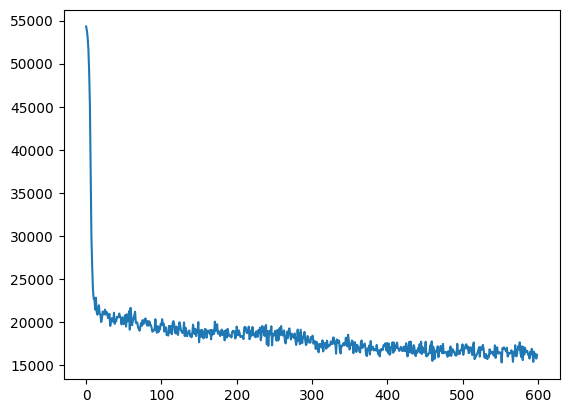

In [13]:
num_epochs = 200
print_per = 100
model.train()
loss_record = []
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        if (epoch == 0):
            loss_record.append(loss.item())
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))
    torch.save(model.state_dict(), f'./epochs_vae/vae_epoch_{epoch + 1}.pth')

plt.plot(loss_record)

## Gerando imagens:

(784,)
torch.Size([784])


/tmp/ipykernel_38381/1676568931.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./epochs_vae/vae_epoch_200.pth'))


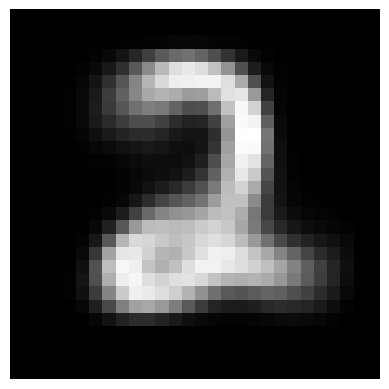

In [21]:
print(model(images)[0].data[0].numpy().shape)
image1 = random.choice(images)
print(image1.shape)
model.load_state_dict(torch.load(f'./epochs_vae/vae_epoch_200.pth'))
plt.imshow(model(images)[0].data[10].numpy().reshape(28, 28), cmap='gray')
plt.axis("off")
plt.show(block=True)

## Gerando uma imagem do VAE:

/tmp/ipykernel_38381/380234590.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./epochs_vae/vae_epoch_200.pth'))


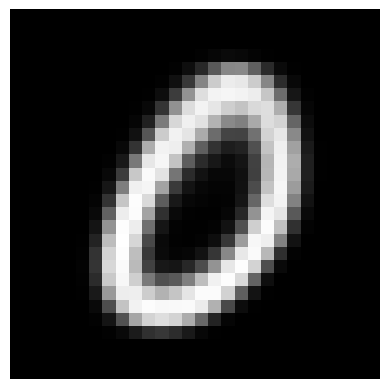

In [37]:
def generate_image(model):
    model.eval()
    model.load_state_dict(torch.load(f'./epochs_vae/vae_epoch_200.pth'))
    with torch.no_grad():
        z = torch.randn(1, 2)
        sample = model.decode(z).cpu()
        sample = sample.view(28, 28)
        return sample

# for i in range(0, 5000):
#     image, _ = test_dataset[random.choice(range(0, test_size))]
#     plt.imshow(image.view(28, 28), cmap='gray')
#     plt.axis('off')
#     plt.savefig('images_mnist/image_mnist{}'.format(i), bbox_inches='tight', pad_inches=0)
#     plt.close()

image = generate_image(model)
plt.imshow(image.view(28, 28), cmap='gray')
plt.axis('off')
plt.show()

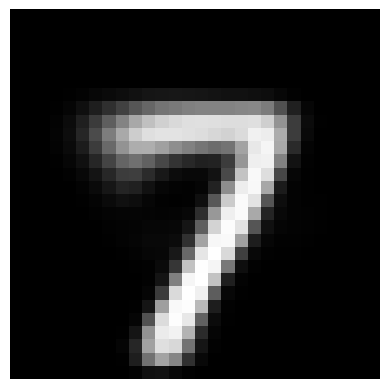

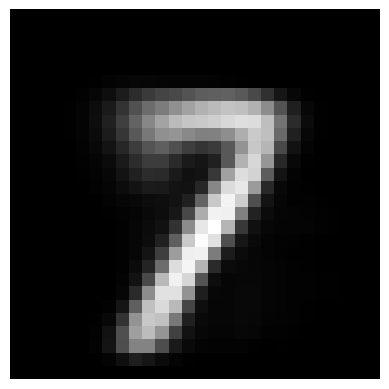

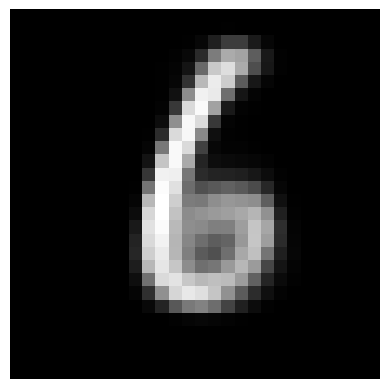

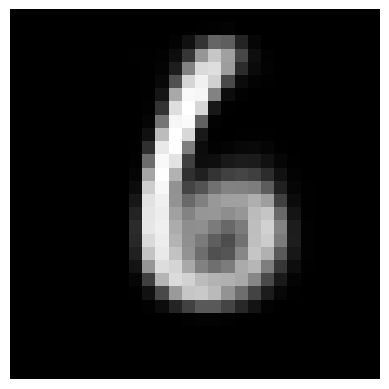

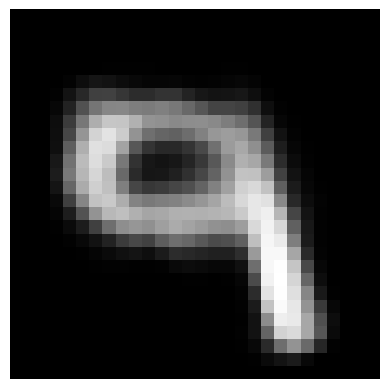

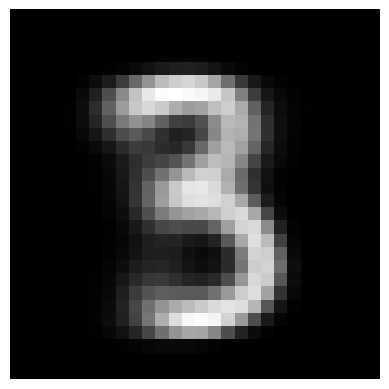

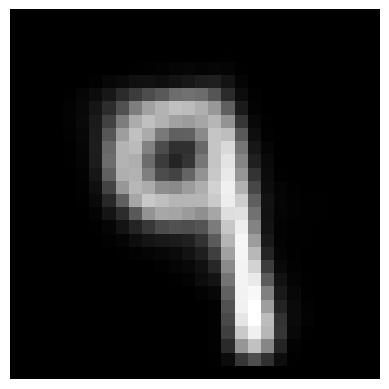

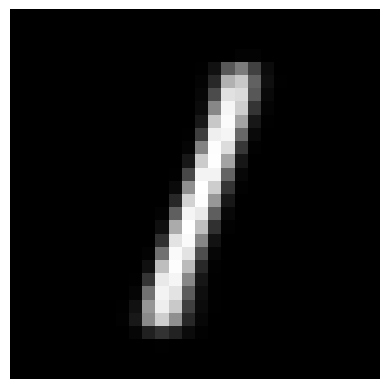

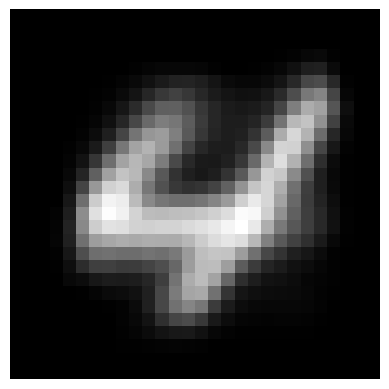

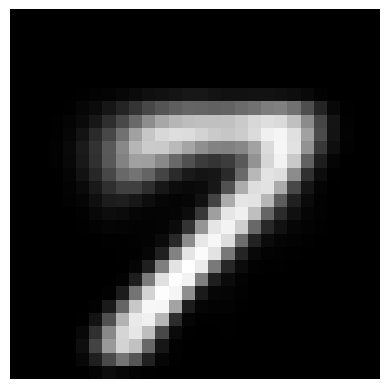

In [38]:
test_loss = 0
print_per = 10
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.reshape(-1, 28*28)
        recon_batch, mu, logvar = model(images)
        test_loss += loss_function(recon_batch, images, mu, logvar).item()
        if (i%print_per == 0):
            plt.imshow(model(images)[0].data[0].numpy().reshape(28, 28), cmap='gray')
            plt.axis("off")
            plt.show(block=True)

torch.Size([784])


/tmp/ipykernel_38381/2864694063.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./epochs_vae/vae_epoch_200.pth'))


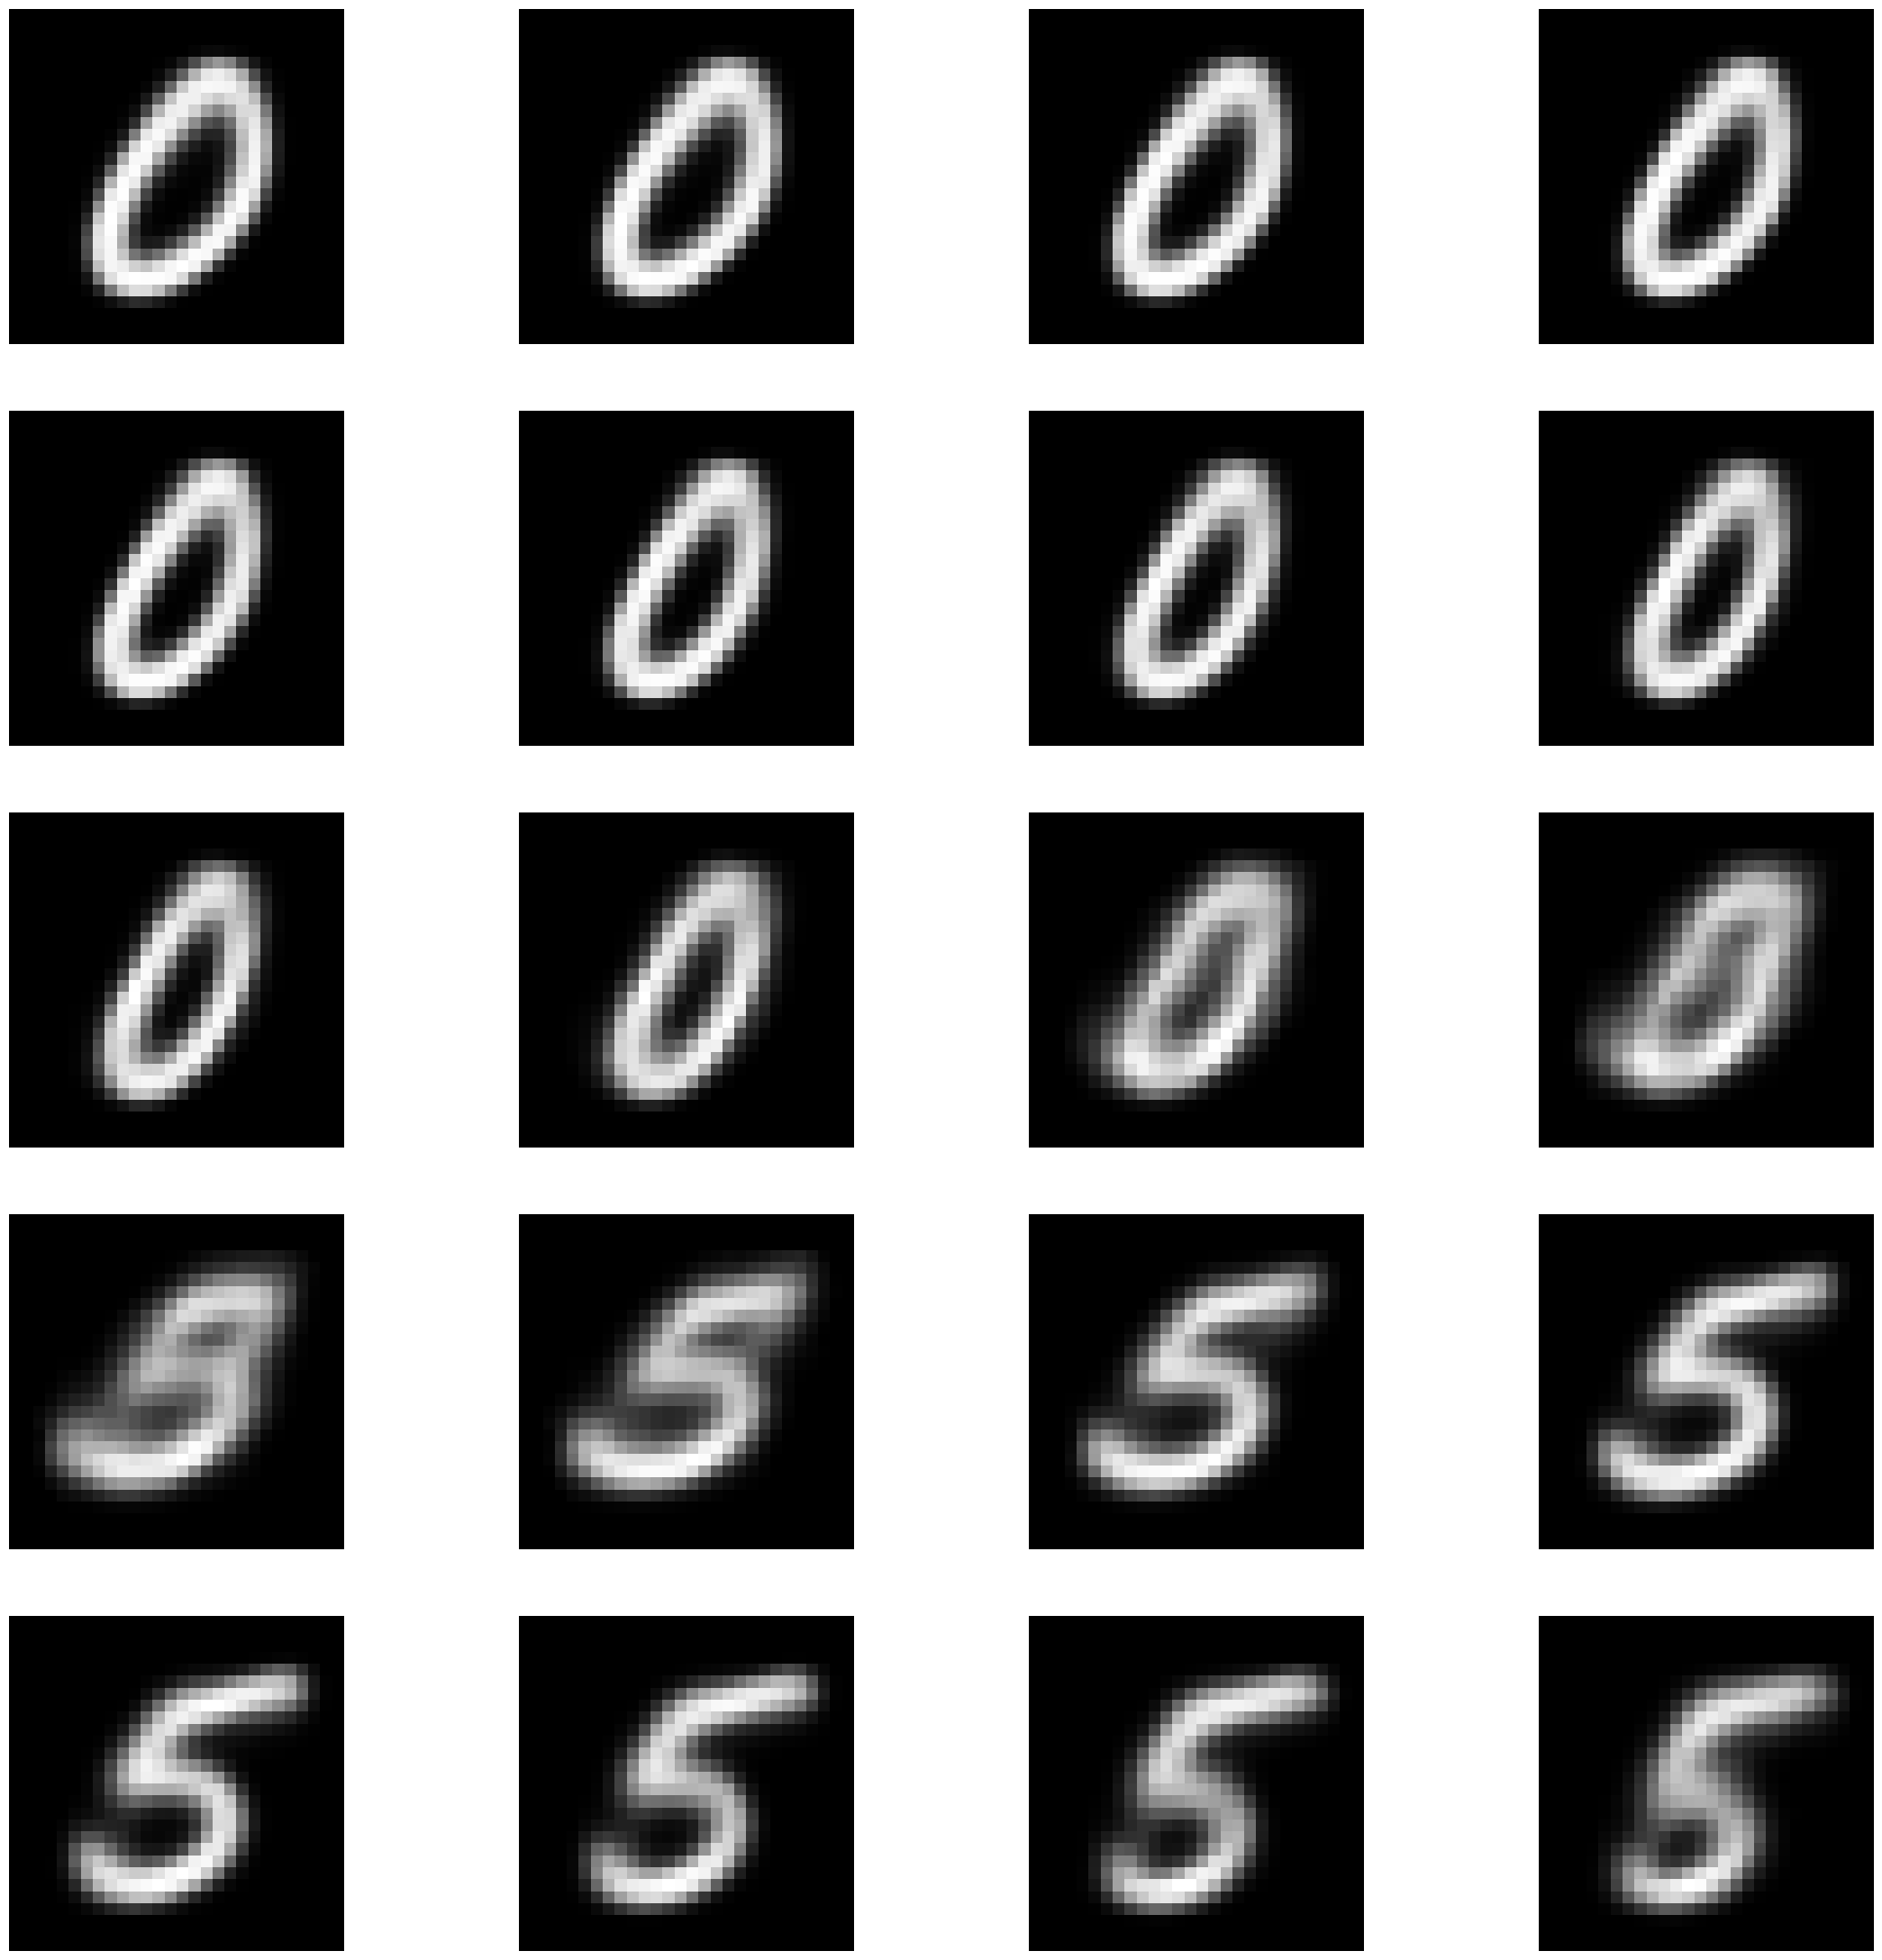

In [40]:
image1 = random.choice(images)
image2 = images[10]#random.choice(images)
print(image2.shape)
model.load_state_dict(torch.load(f'./epochs_vae/vae_epoch_200.pth'))
with torch.no_grad():
    mu1, logvar1 = model.encode(image1)
    std1 = torch.exp(0.5*logvar1)
    mu2, logvar2 = model.encode(image2)
    std2 = torch.exp(0.5*logvar2)

eps_any = torch.randn_like(mu1)
z1 = eps_any.mul(std1).add_(mu1)
z2 = eps_any.mul(std2).add_(mu2)
all_recons = []
for i in range(20):
    z_bet = z1 + torch.full_like(mu1, fill_value = 0.05*i).mul(z2 - z1)
    recon_image = model.decode(z_bet)
    all_recons.append(recon_image)

fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = all_recons[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()

/tmp/ipykernel_38381/1669028168.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./epochs_vae/vae_epoch_200.pth'))


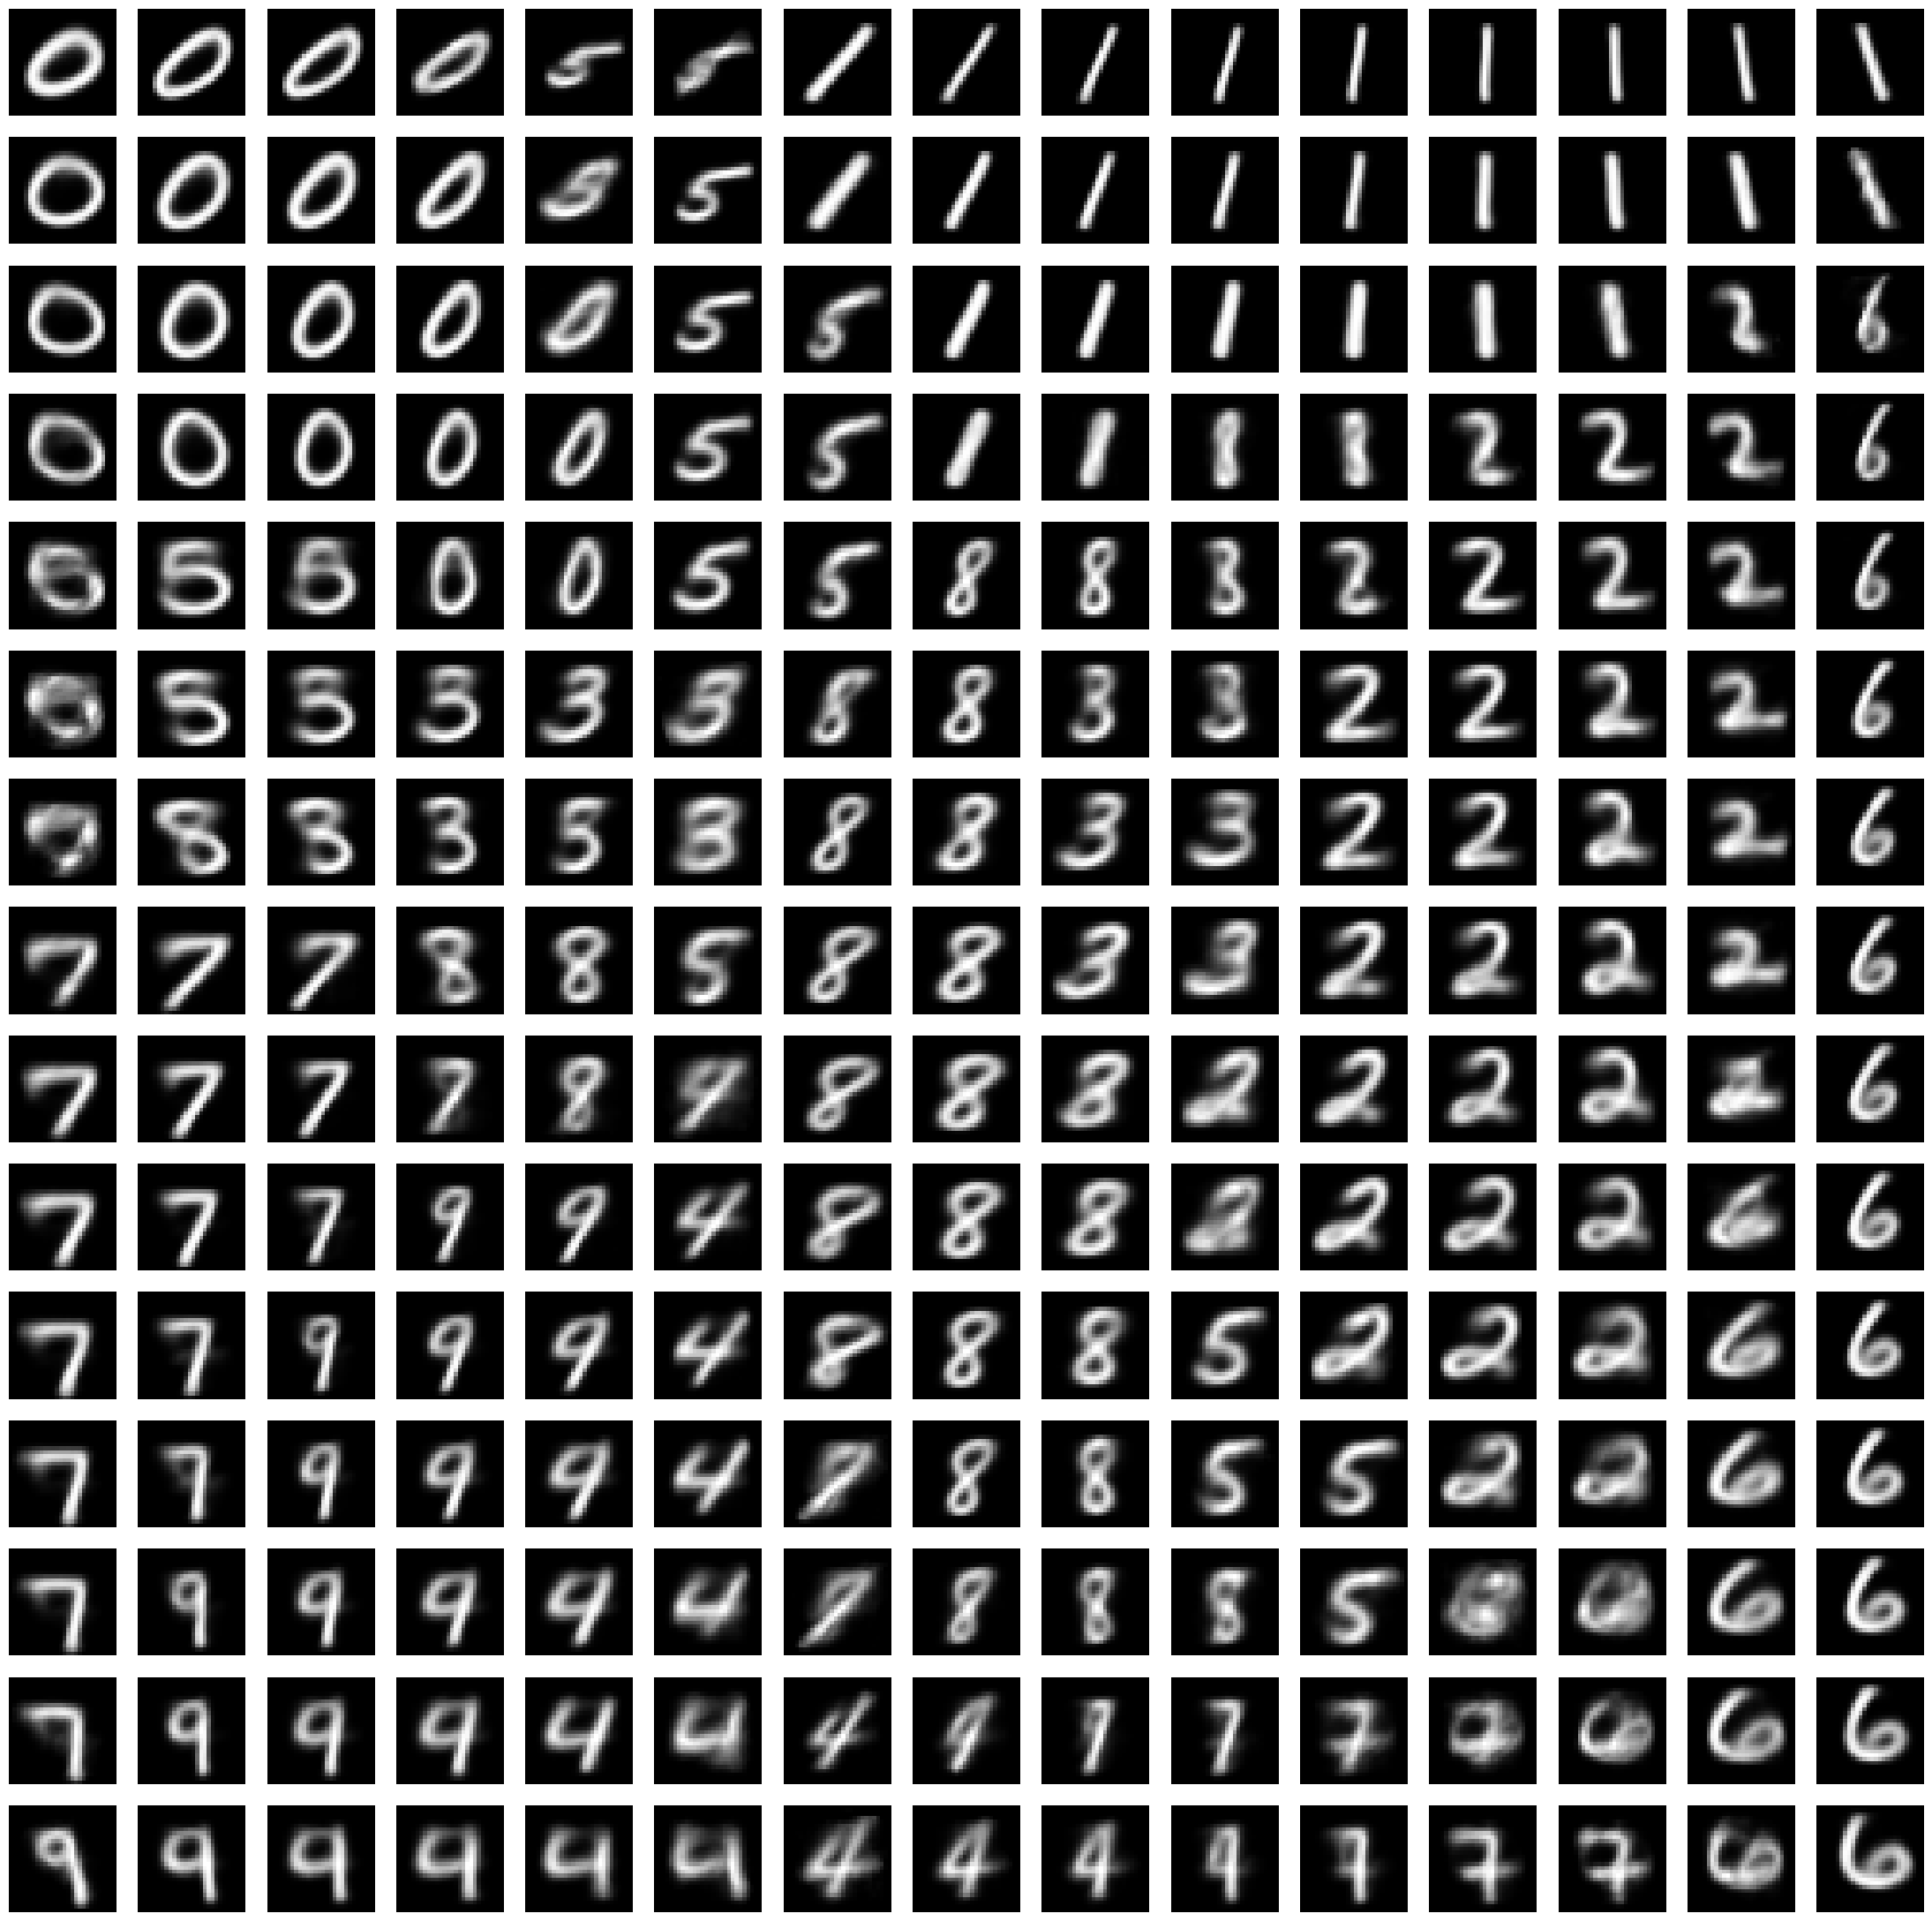

In [48]:
image1 = random.choice(images)
image2 = random.choice(images)

model.load_state_dict(torch.load(f'./epochs_vae/vae_epoch_200.pth'))
with torch.no_grad():
    mu1, logvar1 = model.encode(image1)
    std1 = torch.exp(0.5*logvar1)
    mu2, logvar2 = model.encode(image2)
    std2 = torch.exp(0.5*logvar2)

n = 15
z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))

with torch.no_grad():
    recon_images1 = []
    for xi in z1 :
        for yi in z2 : 
            z_val = torch.zeros_like(mu1)
            z_val[0] = xi
            z_val[1] = yi
            recon_image = model.decode(z_val)
            recon_images1.append(recon_image)

fig=plt.figure(figsize=(28, 28))
columns = 15
rows = 15
for i in range(1, columns*rows +1):
    img = recon_images1[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
plt.show()

(10000, 2)
torch.Size([10000])


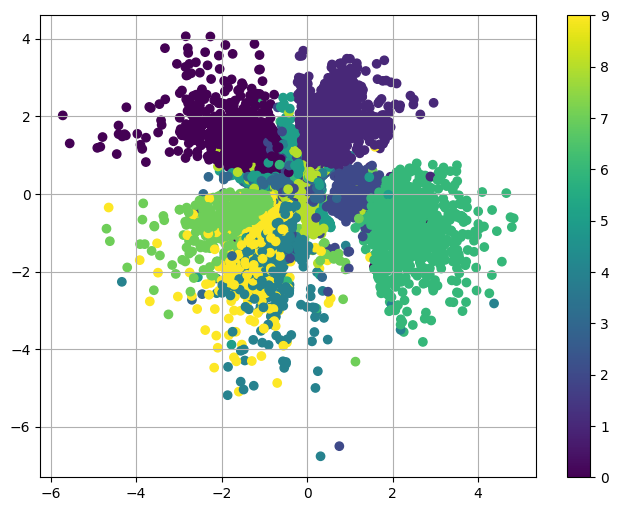

In [58]:
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=60000, shuffle=False)

x_set, y_set = next(iter(test_loader))
x_set = x_set.reshape(-1, 28*28)
z_set = model.encode(x_set)[0].detach().numpy()
print(z_set.shape)
print(y_set.shape)
color = y_set

plt.figure(figsize=(8,6))
plt.scatter(z_set[:, 1], -z_set[:, 0], c=color, cmap = "viridis")
plt.colorbar()
plt.grid()
